In [21]:
classes = [
		"pink primrose",
		"hard-leaved pocket orchid",
		"canterbury bells",
		"sweet pea",
		"english marigold",
		"tiger lily",
		"moon orchid",
		"bird of paradise",
		"monkshood",
		"globe thistle",
		"snapdragon",
		"colt's foot",
		"king protea",
		"spear thistle",
		"yellow iris",
		"globe-flower",
		"purple coneflower",
		"peruvian lily",
		"balloon flower",
		"giant white arum lily",
		"fire lily",
		"pincushion flower",
		"fritillary",
		"red ginger",
		"grape hyacinth",
		"corn poppy",
		"prince of wales feathers",
		"stemless gentian",
		"artichoke",
		"sweet william",
		"carnation",
		"garden phlox",
		"love in the mist",
		"mexican aster",
		"alpine sea holly",
		"ruby-lipped cattleya",
		"cape flower",
		"great masterwort",
		"siam tulip",
		"lenten rose",
		"barbeton daisy",
		"daffodil",
		"sword lily",
		"poinsettia",
		"bolero deep blue",
		"wallflower",
		"marigold",
		"buttercup",
		"oxeye daisy",
		"common dandelion",
		"petunia",
		"wild pansy",
		"primula",
		"sunflower",
		"pelargonium",
		"bishop of llandaff",
		"gaura",
		"geranium",
		"orange dahlia",
		"pink-yellow dahlia?",
		"cautleya spicata",
		"japanese anemone",
		"black-eyed susan",
		"silverbush",
		"californian poppy",
		"osteospermum",
		"spring crocus",
		"bearded iris",
		"windflower",
		"tree poppy",
		"gazania",
		"azalea",
		"water lily",
		"rose",
		"thorn apple",
		"morning glory",
		"passion flower",
		"lotus",
		"toad lily",
		"anthurium",
		"frangipani",
		"clematis",
		"hibiscus",
		"columbine",
		"desert-rose",
		"tree mallow",
		"magnolia",
		"cyclamen",
		"watercress",
		"canna lily",
		"hippeastrum",
		"bee balm",
		"ball moss",
		"foxglove",
		"bougainvillea",
		"camellia",
		"mallow",
		"mexican petunia",
		"bromelia",
		"blanket flower",
		"trumpet creeper",
		"blackberry lily",
]	

In [22]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
#from tqdm.notebook import tqdm

if (torch.cuda.is_available()):
    torch.cuda.empty_cache()


In [23]:
# Means and stds for flowers dataset
means, stds = (0.433, 0.382, 0.296), (0.262, 0.213, 0.225)

batch_size = 16
EPOCHS = 60
LEARNING_RATE =0.001
MOMENTUM=0.9

In [24]:
def imshow(img, title=None):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  ax = plt.subplot() 
  ax.imshow(np.transpose(npimg, (1, 2, 0)))
  if (title is not None):
    ax.set_title(title)
  plt.show()

In [25]:
y = np.array(classes)


In [26]:
# composing several transforms together
transform_test = transforms.Compose([
	transforms.CenterCrop(size=500),
	transforms.Resize((256,256)), 
	transforms.ToTensor(), # to tensor object
	transforms.Normalize(means, stds)]) # mean, std over rbg values

transform_train = transforms.Compose([
	transforms.CenterCrop(size=500),
	transforms.Resize((256,256)),
	transforms.RandomRotation(20),
	transforms.RandomHorizontalFlip(0.5), 
	transforms.ToTensor(), # to tensor object
	transforms.Normalize(means, stds)]) # mean, std over rbg values

In [27]:

# load train data
trainset = torchvision.datasets.Flowers102(root='./data', split="train",
										download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
											shuffle=True)

# load test data
testset = torchvision.datasets.Flowers102(root='./data', split="test",
										 download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
										 shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


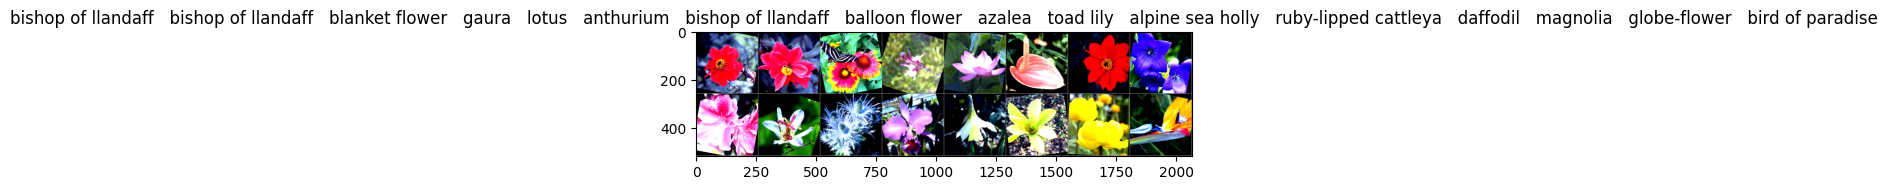

In [28]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images), np.apply_along_axis('   '.join, 0 ,y[labels]))

In [29]:
class Net(nn.Module):
    def __init__(self, num_channels, classes):
        super(Net, self).__init__() 
        self.features = nn.Sequential (
            nn.Conv2d(in_channels=num_channels, out_channels=128, kernel_size=(3,3)),
            nn.ReLU(),
            #nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3)),
            #nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3)),
            #nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3)),
            #nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=64 * 30 * 30, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=classes),
            nn.LogSoftmax(dim=1)    
        )

    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1) 
        output = self.classifier(x)
        return output  

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [32]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        with torch.autocast(device_type='cuda'):
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
        

        loss.backward()
        optimizer.step()

        epoch_loss += float(loss.item())
        epoch_acc += float(acc.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(3, len(classes))
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)
count_parameters(model)

240606118

In [34]:
if (True):
    x, _ = next(dataiter)
    x = x.to(device)
    x = model.features(x)
    print(x.shape)


torch.Size([16, 64, 30, 30])


In [35]:
epoch_loss, epoch_acc = train(model, trainloader, optimizer, criterion, device)

In [36]:
print(epoch_loss)
print(epoch_acc)

4.625627651810646
0.0048828125


In [37]:


best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01
	Train Loss: 4.624 | Train Acc: 1.07%
Epoch: 02
	Train Loss: 4.624 | Train Acc: 0.88%
Epoch: 03
	Train Loss: 4.622 | Train Acc: 1.46%
Epoch: 04
	Train Loss: 4.619 | Train Acc: 2.15%
Epoch: 05
	Train Loss: 4.613 | Train Acc: 2.44%
Epoch: 06
	Train Loss: 4.596 | Train Acc: 1.95%
Epoch: 07
	Train Loss: 4.546 | Train Acc: 2.15%
Epoch: 08
	Train Loss: 4.418 | Train Acc: 2.15%
Epoch: 09
	Train Loss: 4.328 | Train Acc: 1.56%
Epoch: 10
	Train Loss: 4.260 | Train Acc: 1.76%
Epoch: 11
	Train Loss: 4.174 | Train Acc: 2.96%
Epoch: 12
	Train Loss: 4.159 | Train Acc: 3.52%
Epoch: 13
	Train Loss: 4.055 | Train Acc: 5.24%
Epoch: 14
	Train Loss: 3.979 | Train Acc: 6.45%
Epoch: 15
	Train Loss: 3.839 | Train Acc: 9.02%
Epoch: 16
	Train Loss: 3.772 | Train Acc: 8.98%
Epoch: 17
	Train Loss: 3.589 | Train Acc: 11.17%
Epoch: 18
	Train Loss: 3.502 | Train Acc: 12.89%
Epoch: 19
	Train Loss: 3.443 | Train Acc: 13.31%
Epoch: 20
	Train Loss: 3.272 | Train Acc: 18.03%
Epoch: 21
	Train Loss: 3.212 | Train

In [38]:
def testing(model, iterator, criterion):
  total_loss = 0
  total_acc = 0
  model.eval()
  with torch.no_grad():
    for images, labels in iterator:
      images = images.to(device)
      labels = labels.to(device)

      pred_y= model.forward(images)

      loss = criterion(pred_y, labels)
      acc = calculate_accuracy(pred_y, labels)

      total_loss += loss
      total_acc += acc

    return total_loss / len(iterator), total_acc / len(iterator)

In [39]:
testing_loss, testing_acc = testing(model, testloader, criterion)

In [40]:
print(testing_loss, testing_acc)

tensor(4.5398, device='cuda:0') tensor(0.2411, device='cuda:0')
